In [1]:
%cd ~/mechanistic-unlearning
%load_ext autoreload
%autoreload 2
import functools
import os
import gc
import json
# from tkinter import font
import sys

from dataset.custom_dataset import PairedInstructionDataset
import torch

from transformer_lens import HookedTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset
import einops
from transformer_lens import ActivationCache
import time

# project_root = os.path.abspath(os.path.dirname(__file__))
project_root = "/data/phillip_guo/mechanistic-unlearning"

# Add the project root and its subdirectories to the Python path
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'masks_learning'))
sys.path.insert(0, os.path.join(project_root, 'localizations'))
sys.path.insert(0, os.path.join(project_root, 'tasks'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/root/mechanistic-unlearning


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "google/gemma-7b"
model_type = "gemma_7b"
model = HookedTransformer.from_pretrained(
    model_name,
    device='cuda',
    default_padding_side="left",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)
tokenizer = model.tokenizer

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]


Loaded pretrained model google/gemma-7b into HookedTransformer


## Develop CounterFact Dataset

In [3]:
import pandas as pd

counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split=model_type).to_pandas()

In [4]:
def get_token_sequence_pos(prompt_list, token_strs, batch_size=64):
    
    substring_start_positions = []
    substring_end_positions = []
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
        
        tokenized_substrings = tokenizer(token_strs[i:i+batch_size]).input_ids
        for j in range(len(tokenized_substrings)):
            if tokenized_substrings[j][0] == tokenizer.bos_token_id:
                substring = tokenized_substrings[j][1:]
            else:
                substring = tokenized_substrings[j]
            substring = torch.tensor(substring)
            prompt = tokenized_prompts.input_ids[j]
            # print(prompt, substring)

            # Find the last occurrence of the substring
            for k in range(len(prompt) - len(substring), -1, -1):
                if torch.all(prompt[k:k+len(substring)] == substring):
                    substring_start_positions.append(k - len(prompt))
                    substring_end_positions.append(k + len(substring) - len(prompt))
                    # if 0, then we are at the end of the prompt, we should treat it weird after
                    # if k - len(prompt) < 0:
                    #     substring_start_positions.append(k - len(prompt))
                    # else:
                    #     substring_start_positions.append(len(prompt))
                    # if k+len(substring) < len(prompt):
                    #     substring_end_positions.append((k+len(substring))-len(prompt))
                    # else:
                    #     substring_end_positions.append(len(prompt))
                    break
            else:
                # If substring not found, append 1
                substring_start_positions.append(1)
                substring_end_positions.append(1)
    return substring_start_positions, substring_end_positions

substring_start_positions, substring_end_positions = get_token_sequence_pos((counterfact_df["prompt"] + counterfact_df["target_true"]).tolist(), counterfact_df["target_true"].tolist())
# # model process full prompt

  9%|▉         | 32/343 [00:00<00:00, 314.66it/s]

100%|██████████| 343/343 [00:01<00:00, 325.43it/s]


In [5]:
# # model process full prompt
# batch_size = 64
# prompt_list = (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()
# tokenized_substrings = tokenizer(counterfact_df["target_true"].tolist()).input_ids

# correct_probs = []
# for i in tqdm(range(0, len(prompt_list), batch_size)):
#     tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
#     prompt_toks = tokenized.input_ids
#     attn_mask = tokenized.attention_mask
#     current_substring_positions = substring_positions[i:i+batch_size]

#     with torch.set_grad_enabled(False):
#         output = model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())
    
#     for j in range(len(current_substring_positions)):
#         # check [pos-1: -1]
#         answer_preds = output[j, current_substring_positions[j]-1: -1]

#         if tokenized_substrings[i+j][0] == tokenizer.bos_token_id:
#             label = tokenized_substrings[i+j][1:]
#         else:
#             label = tokenized_substrings[i+j]
#         label = torch.tensor(label)
        
#         # get probability of correct answer across all label tokens (answer_preds is answer_len x vocab, label is shape (answer_len,))
#         probs = torch.nn.functional.softmax(answer_preds, dim=-1)
#         correct_prob = probs[torch.arange(len(label)), label]
#         # multiply across answer_len
#         correct_probs.append(torch.prod(correct_prob).item())
    
# print(torch.tensor(correct_probs).mean())
# import matplotlib.pyplot as plt
# plt.hist(correct_probs)
# plt.show()

## Filter CFact for facts which model gets correct

In [6]:
correct_prob_threshold = 0.5
# filter for when model gets first token correct (assuming future tokens will also be correct)
counterfact_df = counterfact_df[counterfact_df["prob_of_correct_answer"] > correct_prob_threshold]

## Cache Activations

In [7]:
# get activations at these positions
from collections import defaultdict
def retrieve_acts(model, prompt_list, batch_size, layer=None, to_cpu=False, truncate_length=None, sequence_pos=None):
    if layer is None:
        caches = defaultdict(list)
    else:
        caches = []
    if isinstance(sequence_pos, int):
        sequence_pos = torch.tensor([sequence_pos] * len(prompt_list))
    elif sequence_pos is None:
        sequence_pos = torch.tensor([-1] * len(prompt_list))
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        attn_mask = tokenized_prompts.attention_mask
        if truncate_length is not None:
            if len(prompt_toks[0]) > truncate_length:
                print(f"Prompt {i} is too long, truncating")
                prompt_toks = prompt_toks[:, -truncate_length:]
                attn_mask = attn_mask[:, -truncate_length:]

        _, cache = model.run_with_cache(
            prompt_toks,
            attention_mask=attn_mask,
            names_filter = (lambda name: f"hook_resid_post" in name) if layer is None else (f"blocks.{layer}.hook_resid_post")
        )
        batch_sequence_pos_index = sequence_pos[i:i+batch_size]

        if layer is None:
            for k, v in cache.items():
                key_layer = int(k.split(".")[1])

                if isinstance(sequence_pos, torch.Tensor) and len(sequence_pos.shape) > 1:
                    batch_index = torch.arange(v.shape[0]).unsqueeze(-1).repeat(1, batch_sequence_pos_index.shape[1])
                else:
                    batch_index = torch.arange(v.shape[0])
                sequence_cache = v[batch_index, batch_sequence_pos_index, :]
                if to_cpu:
                    sequence_cache = sequence_cache.cpu()
                caches[key_layer].append(sequence_cache)
        else:
            if isinstance(sequence_pos, torch.Tensor) and len(sequence_pos.shape) > 1:
                batch_index = torch.arange(cache.shape[0]).unsqueeze(-1).repeat(1, batch_sequence_pos_index.shape[1])
            else:
                batch_index = torch.arange(cache.shape[0])
            sequence_cache = cache[f"blocks.{layer}.hook_resid_post"][batch_index, batch_sequence_pos_index, :]
            caches.append(sequence_cache.cpu() if to_cpu else sequence_cache)
    if layer is None:
        for k, v in caches.items():
            caches[k] = torch.cat(v, dim=0)
    else:
        caches = torch.cat(caches, dim=0)
    return caches


In [8]:
import pickle
load_acts = False
if load_acts:
    with open(f"experiments/gemma_7b_manual/counterfact_true_false_acts_{correct_prob_threshold=}.pkl", "rb") as f:
        data = pickle.load(f)
        true_acts = data["true_acts"]
        false_acts = data["false_acts"]
else:
    true_acts = retrieve_acts(model, [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()], batch_size=32, sequence_pos=-1, to_cpu=True)
    false_acts = retrieve_acts(model, [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()], batch_size=32, sequence_pos=-1, to_cpu=True)
    true_acts = {layer: true_acts[layer].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    false_acts = {layer: false_acts[layer].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    with open(f"experiments/gemma_7b_manual/counterfact_true_false_acts_{correct_prob_threshold=}.pkl", "wb") as f:
        pickle.dump({"true_acts": true_acts, "false_acts": false_acts}, f)


  0%|          | 0/68 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


In [9]:
for layer in range(model.cfg.n_layers):
    print(true_acts[layer].shape)
    print(false_acts[layer].shape)
    print(true_acts[layer].mean())
    print(false_acts[layer].mean())

(2169, 3072)
(2169, 3072)
-0.0025819433
-0.0025826246
(2169, 3072)
(2169, 3072)
-0.0011457064
-0.0011461582
(2169, 3072)
(2169, 3072)
0.0011484821
0.0011305264
(2169, 3072)
(2169, 3072)
0.00060208334
0.0005842908
(2169, 3072)
(2169, 3072)
-0.0014300587
-0.0014429024
(2169, 3072)
(2169, 3072)
5.134535e-05
6.540376e-06
(2169, 3072)
(2169, 3072)
-0.00023541748
-0.00024821007
(2169, 3072)
(2169, 3072)
-0.00029444986
-0.00030166094
(2169, 3072)
(2169, 3072)
-0.00076410454
-0.00074527645
(2169, 3072)
(2169, 3072)
-0.0014443728
-0.0014505908
(2169, 3072)
(2169, 3072)
-0.00012027039
-0.00010959621
(2169, 3072)
(2169, 3072)
0.00076561054
0.00071120413
(2169, 3072)
(2169, 3072)
-0.0009427543
-0.0009778517
(2169, 3072)
(2169, 3072)
-0.0005797604
-0.000627281
(2169, 3072)
(2169, 3072)
0.00020480214
0.00015890505
(2169, 3072)
(2169, 3072)
0.00055026566
0.0005614716
(2169, 3072)
(2169, 3072)
-0.0006476216
-0.00073130464
(2169, 3072)
(2169, 3072)
-0.00026467064
-0.00023401255
(2169, 3072)
(2169, 3072

## Train Probes

In [10]:
from sklearn.preprocessing import StandardScaler
from multiprocessing.dummy import Pool as ThreadPool
def train_test_probe(X_train, X_test, y_train, y_test, preprocess=True):
    if preprocess:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    clf = LogisticRegression(solver='sag').fit(X_train, y_train)
    return clf.score(X_test, y_test), clf

results_dict = {}
def get_shuffle_indices(length):
    np.random.seed(42)  # Set a constant seed
    return np.random.permutation(length)

shuffle_indices = get_shuffle_indices(len(counterfact_df["target_true"]) + len(counterfact_df["target_false"])) # should look like array([3975, 1448, 2662, ..., 3092, 3772,  860])
print(shuffle_indices)
split_index = int(0.8 * len(shuffle_indices))

def format_data(layer):
    total_acts = np.concatenate([true_acts[layer], false_acts[layer]], axis=0)
    total_labels = np.concatenate([np.ones(true_acts[layer].shape[0]), np.zeros(false_acts[layer].shape[0])], axis=0)
    # shuffle and split
    total_acts = total_acts[shuffle_indices]
    total_labels = total_labels[shuffle_indices]
    X_train = total_acts[:split_index]
    X_test = total_acts[split_index:]
    y_train = total_labels[:split_index]
    y_test = total_labels[split_index:]
    return X_train, X_test, y_train, y_test

def probe_layer(layer):
    X_train, X_test, y_train, y_test = format_data(layer)
    return train_test_probe(X_train, X_test, y_train, y_test)


load_probes = False
if load_probes:
    with open(f"experiments/gemma_7b_manual/counterfact_clfs_{correct_prob_threshold=}.pkl", "rb") as f:
        data = pickle.load(f)
        clfs = data["clfs"]
        results_dict = data["results_dict"]
else:
    clfs = {}
    for layer in tqdm(range(model.cfg.n_layers)):
        total_acts = np.concatenate([true_acts[layer], false_acts[layer]], axis=0)
        total_labels = np.concatenate([np.ones(true_acts[layer].shape[0]), np.zeros(false_acts[layer].shape[0])], axis=0)
        # shuffle and split
        total_acts = total_acts[shuffle_indices]
        total_labels = total_labels[shuffle_indices]
        split_index = int(0.8 * total_acts.shape[0])
        X_train = total_acts[:split_index]
        X_test = total_acts[split_index:]
        y_train = total_labels[:split_index]
        y_test = total_labels[split_index:]
        test_acc, clf = train_test_probe(X_train, X_test, y_train, y_test)
        results_dict[layer] = test_acc
        clfs[layer] = clf
    print(results_dict)

    with open(f"experiments/gemma_7b_manual/counterfact_clfs_{correct_prob_threshold=}.pkl", "wb") as f:
        pickle.dump({"clfs": clfs, "results_dict": results_dict}, f)
# print("Starting multiprocessing")
# start_time = time.time()
# with ThreadPool(processes=model.cfg.n_layers) as pool:  # Using ThreadPool
#     results = pool.starmap(probe_layer, [(layer,) for layer in range(model.cfg.n_layers)])
# end_time = time.time()
# print(f"Time taken: {end_time - start_time} seconds")
# print(results)

[3975 1448 2662 ... 3092 3772  860]


  0%|          | 0/28 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 1/28 [00:07<03:13,  7.17s/it]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 2/28 [00:14<03:07,  7.23s/it]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 3/28 [00:21<03:00,  7.23s/it]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 4/28 [00:28<02:53,  7.23s/it]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reach

{0: 0.511520737327189, 1: 0.5887096774193549, 2: 0.6820276497695853, 3: 0.6716589861751152, 4: 0.7188940092165899, 5: 0.7695852534562212, 6: 0.8617511520737328, 7: 0.8559907834101382, 8: 0.8502304147465438, 9: 0.868663594470046, 10: 0.9297235023041475, 11: 0.9470046082949308, 12: 0.9470046082949308, 13: 0.956221198156682, 14: 0.9642857142857143, 15: 0.9642857142857143, 16: 0.9746543778801844, 17: 0.9723502304147466, 18: 0.9746543778801844, 19: 0.9688940092165899, 20: 0.9723502304147466, 21: 0.9735023041474654, 22: 0.9631336405529954, 23: 0.9631336405529954, 24: 0.9596774193548387, 25: 0.9516129032258065, 26: 0.9481566820276498, 27: 0.9435483870967742}


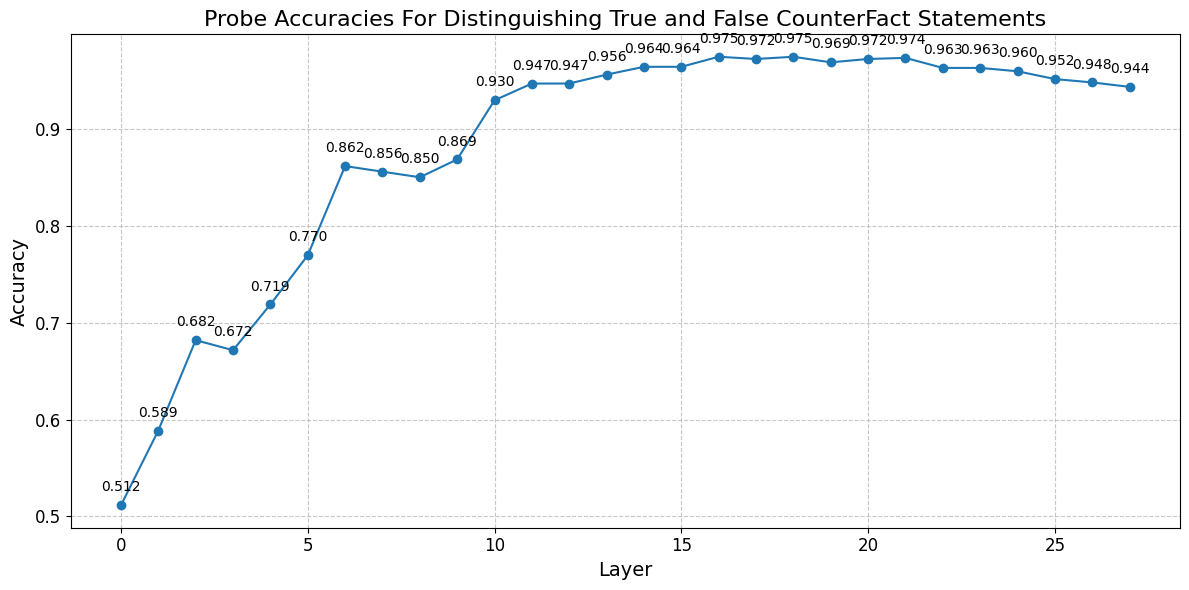

In [11]:
import matplotlib.pyplot as plt

# results_dict = {0: 0.5231523722627737, 1: 0.5882755474452555, 2: 0.6528284671532847, 3: 0.6526003649635036, 4: 0.6905793795620438, 5: 0.7166970802919708, 6: 0.7844434306569343, 7: 0.7874087591240876, 8: 0.7831888686131386, 9: 0.7979014598540146, 10: 0.8561815693430657, 11: 0.8616560218978102, 12: 0.8640510948905109, 13: 0.8622262773722628, 14: 0.8641651459854015, 15: 0.864507299270073, 16: 0.8638229927007299, 17: 0.8669023722627737, 18: 0.8657618613138686, 19: 0.8664461678832117, 20: 0.864507299270073, 21: 0.8654197080291971, 22: 0.864279197080292, 23: 0.8598312043795621, 24: 0.8560675182481752, 25: 0.8540145985401459, 26: 0.8447764598540146, 27: 0.84375}
# Extract layers and accuracies from the results_dict
layers = list(results_dict.keys())
accuracies = list(results_dict.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(layers, accuracies, marker='o')

# Customize the plot
plt.title('Probe Accuracies For Distinguishing True and False CounterFact Statements', fontsize=16)
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on the points
for i, accuracy in enumerate(accuracies):
    plt.annotate(f'{accuracy:.3f}', (layers[i], accuracy), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.tight_layout()
plt.show()

## Perform Ablations

In [12]:
import einops
# get mean ablation cache
load_mean_cache = True

if load_mean_cache:
    with open(f"experiments/gemma_7b_manual/counterfact_mean_caches_{correct_prob_threshold=}.pkl", "rb") as f:
        data = pickle.load(f)
        attn_cache = data["attn_cache"]
        mlp_cache = data["mlp_cache"]
    for layer in range(model.cfg.n_layers):
        attn_cache[layer] = attn_cache[layer].cuda()
        mlp_cache[layer] = mlp_cache[layer].cuda()

else:
    attn_cache = {}
    mlp_cache = {}
    for layer in range(model.cfg.n_layers):
        attn_cache[layer] = torch.zeros((16, model.cfg.d_head)).to("cuda")
        mlp_cache[layer] = torch.zeros((model.cfg.d_model)).to("cuda")

    batch_size = 16
    all_prompts = [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()] + [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()]
    with torch.set_grad_enabled(False):
        for i in tqdm(range(0, len(all_prompts), batch_size)):
            tokenized_prompts = tokenizer(all_prompts[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
            prompt_toks = tokenized_prompts.input_ids
            attn_mask = tokenized_prompts.attention_mask

            _, cache = model.run_with_cache(prompt_toks.cuda(), attention_mask=attn_mask.cuda(), names_filter=lambda name: 'hook_z' in name or 'mlp_out' in name)
            for layer in range(model.cfg.n_layers):
                attn_cache[layer] += einops.reduce(cache[f'blocks.{layer}.attn.hook_z'], "batch seq head d_head -> head d_head", "mean")
                mlp_cache[layer] += einops.reduce(cache[f'blocks.{layer}.hook_mlp_out'], "batch seq d_mlp -> d_mlp", "mean")

    for layer in range(model.cfg.n_layers):
        attn_cache[layer] = (attn_cache[layer] / (len(all_prompts) // batch_size)).cpu()
        mlp_cache[layer] = (mlp_cache[layer] / (len(all_prompts) // batch_size)).cpu()
    
    with open(f"experiments/gemma_7b_manual/counterfact_mean_caches_{correct_prob_threshold=}.pkl", "wb") as f:
        pickle.dump({"attn_cache": attn_cache, "mlp_cache": mlp_cache}, f)
    for layer in range(model.cfg.n_layers):
        attn_cache[layer] = attn_cache[layer].cuda()
        mlp_cache[layer] = mlp_cache[layer].cuda()

In [13]:
all_prompts = [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()] + [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()]
subject_list = [x for x in counterfact_df["subject"]] + [x for x in counterfact_df["subject"]]
start_subject_pos, end_subject_pos = get_token_sequence_pos(all_prompts, subject_list)
subject_ranges = list(zip(start_subject_pos, end_subject_pos))
tokenized = tokenizer(all_prompts[:16], return_tensors="pt", padding=True)
for i in range(16):
    input_ids = tokenized.input_ids[i]
    print(tokenizer.decode(input_ids[subject_ranges[i][0]:subject_ranges[i][1]]))

  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 68/68 [00:00<00:00, 109.02it/s]

 Danielle Darrieux
 Thomas Joannes Stieltjes
Apple A5
 The Icelandic Dream
 Monell Chemical Senses Center
 Jean Galland
Tapio Kantanen
Toyota Cresta
Windows Embedded CE 6.0
Nathuram Godse
Stefanos Stratigos
Hohenlohe-Langenburg
 Thoranai
Honda Insight
 Northeastern University
 Cees Nooteboom


In [16]:
# Try ablating every head
# get results of probes for 
default_labels = np.concatenate([np.ones(len(counterfact_df["target_true"])), np.zeros(len(counterfact_df["target_false"]))], axis=0)
def evaluate_cache(caches, probes, shuffle_indices=shuffle_indices, split_index=split_index, labels=default_labels):
    correct_responses = {}
    accuracies = {}
    for layer in range(model.cfg.n_layers):
        X_train = caches[layer][shuffle_indices][:split_index]
        X_test = caches[layer][shuffle_indices][split_index:]
        y_train = labels[shuffle_indices][:split_index]
        y_test = labels[shuffle_indices][split_index:]
        clf = probes[layer]
        accuracies[layer] = clf.score(X_test, y_test)
        # get list of 0s and 1s for each element in test, 0 if probe is wrong and 1 if probe is right
        probe_results = clf.predict(X_test)
        correct_responses[layer] = (probe_results == y_test).astype(int)
    return correct_responses, accuracies

def mean_ablate_subject(prompt_list, subject_list, layers, head=None, head_dict=None, attn=False, mlp=False, batch_size=32):
    start_subject_pos, end_subject_pos = get_token_sequence_pos(prompt_list, subject_list)
    subject_ranges = list(zip(start_subject_pos, end_subject_pos))

    """
    Mean ablate subject of prompt for particular layer. Then, run probes and see which prompts the probes get wrong.
    prompt_list and subject_list should be same length
    """
    if isinstance(layers, int):
        layers = [layers]
    if isinstance(head, int):
        head = [head]

    if head is not None and head_dict is None:
        head_dict = {layer: head for layer in layers}

    caches = defaultdict(list)
    if attn:
        def mean_ablate_hook(input, hook, layer, head, ablation_ranges):
            """
            ablation_ranges is a list of tuples of the form (start, end) (inclusive of start, noninclusive of end) for each sequence in the batch
            """
            # input is batch seq heads d_head
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    input[b, ablation_ranges[b][0]:, head] = attn_cache[layer][head]
                else:
                    input[b, ablation_ranges[b][0]:ablation_ranges[b][1], head] = attn_cache[layer][head]
            return input
    elif mlp:
        def mean_ablate_hook(input, hook, layer, ablation_ranges):
            """
            ablation_ranges is a list of tuples of the form (start, end) (inclusive of start, noninclusive of end) for each sequence in the batch
            """
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    input[b, ablation_ranges[b][0]:] = mlp_cache[layer]
                else:
                    input[b, ablation_ranges[b][0]:ablation_ranges[b][1]] = mlp_cache[layer]
            return input
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
        prompt_toks = tokenized.input_ids
        attn_mask = tokenized.attention_mask
        hooks = []
        if attn:
            for layer, heads in head_dict.items():
                for head in heads:
                    hooks.append((f"blocks.{layer}.attn.hook_z", lambda input, hook: mean_ablate_hook(input, hook, layer=layer, head=head, ablation_ranges=subject_ranges[i:i+batch_size])))
        elif mlp:
            for layer in layers:
                hooks.append((f"blocks.{layer}.hook_mlp_out"), lambda input, hook: mean_ablate_hook(input, hook, layer=layer, ablation_ranges=subject_ranges[i:i+batch_size]))
        with torch.set_grad_enabled(False):
            with model.hooks(hooks):
                _, cache = model.run_with_cache(prompt_toks.cuda(), attention_mask=attn_mask.cuda(), names_filter=lambda name: 'resid_post' in name)

        for layer in range(model.cfg.n_layers):
            caches[layer].append(cache[f"blocks.{layer}.hook_resid_post"][:, -1, :])
    print("Concatenating caches")
    for layer in range(model.cfg.n_layers):
        caches[layer] = torch.cat(caches[layer], dim=0).cpu().float().numpy()
    # return caches
    return *evaluate_cache(caches, clfs), caches

all_prompts = [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()] + [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()]
subject_list = [x for x in counterfact_df["subject"]] + [x for x in counterfact_df["subject"]]

correct_responses, accuracies, caches = mean_ablate_subject(all_prompts, subject_list, layers=27, attn=True, head=15)

  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 136/136 [00:19<00:00,  7.08it/s]


Concatenating caches


In [15]:
accuracies

{0: 0.48502304147465436,
 1: 0.48502304147465436,
 2: 0.5149769585253456,
 3: 0.4942396313364055,
 4: 0.5149769585253456,
 5: 0.5184331797235023,
 6: 0.5230414746543779,
 7: 0.5172811059907834,
 8: 0.5264976958525346,
 9: 0.5921658986175116,
 10: 0.8974654377880185,
 11: 0.8905529953917051,
 12: 0.8317972350230415,
 13: 0.8133640552995391,
 14: 0.9527649769585254,
 15: 0.8179723502304147,
 16: 0.5921658986175116,
 17: 0.5518433179723502,
 18: 0.5748847926267281,
 19: 0.5483870967741935,
 20: 0.9504608294930875,
 21: 0.6382488479262672,
 22: 0.5207373271889401,
 23: 0.5195852534562212,
 24: 0.5195852534562212,
 25: 0.5149769585253456,
 26: 0.5149769585253456,
 27: 0.7453917050691244}

In [17]:
test_unablated_caches = {layer: np.concatenate([true_acts[layer], false_acts[layer]], axis=0) for layer in range(model.cfg.n_layers)}

{0: array([[-0.03515625, -0.25390625, -0.07519531, ...,  0.19433594,
          0.1171875 ,  0.21191406],
        [-0.02148438, -0.25      , -0.06152344, ...,  0.2109375 ,
          0.11132812,  0.22265625],
        [-0.05078125, -0.27929688, -0.06933594, ...,  0.19042969,
          0.11035156,  0.20996094],
        ...,
        [-0.03320312, -0.25585938, -0.06347656, ...,  0.20996094,
          0.12109375,  0.20605469],
        [-0.06640625, -0.265625  , -0.08300781, ...,  0.21484375,
          0.10253906,  0.22460938],
        [-0.03125   , -0.25195312, -0.07128906, ...,  0.20410156,
          0.12402344,  0.20214844]], dtype=float32),
 1: array([[-0.09179688, -0.23046875, -0.00927734, ...,  0.203125  ,
         -0.03344727,  0.15722656],
        [-0.09375   , -0.24121094, -0.00732422, ...,  0.20898438,
         -0.02441406,  0.15917969],
        [-0.09912109, -0.27734375, -0.01171875, ...,  0.19921875,
         -0.01464844,  0.15625   ],
        ...,
        [-0.09716797, -0.26367188

In [ ]:
attn_correct_responses = defaultdict(dict)
attn_accuracies = defaultdict(dict)
mlp_correct_responses = {}
mlp_accuracies = {}
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        correct_responses, accuracies, _ = mean_ablate_subject(all_prompts, subject_list, attn=True, layers=layer, head=head)
        attn_correct_responses[layer][head] = correct_responses
        attn_accuracies[layer][head] = accuracies
    correct_responses, accuracies, _ = mean_ablate_subject(all_prompts, subject_list, mlp=True, layers=layer)

In [ ]:
# Need to 
# 1. Probe for correct sport with no changes
# 2. Probe for correct sport with just <bos>name
# 3. Probe after meal ablating attention heads after layer 2
# 4. Probe after meal ablating attention heads after layer 2 and just <bos>name

def train_test_probe(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
    clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)
    # clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
    # results[layer] = clf.score(X_test, y_test)
    return clf.score(X_test, y_test)

def probe_last_layer(model, prompt_toks, targets, batch_size=None, layer=None):
    if batch_size is None:
        with torch.set_grad_enabled(False):
            _, cache = model.run_with_cache(
            prompt_toks,
            names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post" if layer is None else f"blocks.{layer}.hook_resid_post"
        )
        if layer is not None:
            cache = cache[f"blocks.{layer}.hook_resid_post"][:, -1, :]
        else:
            cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]
    else:
        caches = []
        for i in range(0, prompt_toks.shape[0], batch_size):
            prompt_toks_batch = prompt_toks[i:i+batch_size]
            _, cache = model.run_with_cache(
                prompt_toks_batch,
                names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post" if layer is None else f"blocks.{layer}.hook_resid_post"
            )
            if layer is not None:
                cache = cache[f"blocks.{layer}.hook_resid_post"][:, -1, :]
            else:
                cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]
            caches.append(cache)
        cache = torch.cat(caches, dim=0)
    print("last layer probe, cache shape: ", cache.shape)
    X = cache.cpu().float().numpy()
    print(X.shape, len(targets))
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train logistic regression
    # clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)

    # test_acc = clf.score(X_test, y_test)
    test_acc = train_test_probe(X, y)
    print(f"Accuracy: {test_acc}")

    return test_acc

def probe_across_layers(model, prompt_toks, targets, batch_size=None, cpu_multiprocessing=True):
    print(prompt_toks.shape)
    if batch_size is None:
        with torch.set_grad_enabled(False):
            _, cache = model.run_with_cache(
                prompt_toks,
                names_filter = lambda name: 'resid_post' in name
            )
            cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0) # layer batch d_model
    else:
        caches = []
        for i in range(0, prompt_toks.shape[0], batch_size):
            prompt_toks_batch = prompt_toks[i:i+batch_size]
            with torch.set_grad_enabled(False):
                _, cache = model.run_with_cache(
                    prompt_toks_batch,
                    names_filter = lambda name: 'resid_post' in name
                )
                # print(cache)
                # print(list(cache.values())[0].shape)
                cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0)
                # print(cache.shape)
            caches.append(cache)
        cache = torch.cat(caches, dim=1)
        # print("Batched Cache: ", cache.shape)
    print(f"Cache completed, {cache.shape}")
    results = []
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)

    X_data = {layer: cache[layer].cpu().float().numpy().reshape(-1, cache[layer].shape[-1]) for layer in range(model.cfg.n_layers)}

    results = {}

    if cpu_multiprocessing:
        import multiprocess as mp
        import os
        from multiprocessing import Manager
        from multiprocessing import Pool
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        print("Trying cpu multiprocessing")
        from multiprocessing.dummy import Pool as ThreadPool

        start_time = time.time()
        with ThreadPool(processes=model.cfg.n_layers) as pool:  # Using ThreadPool
            results = pool.starmap(train_test_probe, [(X_data[layer], y) for layer in range(model.cfg.n_layers)])
        end_time = time.time()
        print(f"Time taken: {end_time - start_time} seconds")
        # with Pool(processes=2) as pool:
        #     results = pool.starmap(train_test_probe, [(X_data[layer], y) for layer in range(2)])
        print("finished multiprocessing")
        print(results)
        # Convert list of tuples to dictionary
        results_dict = {layer: results[i] for i, layer in enumerate(range(model.cfg.n_layers))}
        print(results_dict)

        # all_processes = {}
        # for layer in range(1):
        #     m = mp.Process(target=train_test_probe, args=(X_data[layer], y, results))
        #     all_processes[layer] = m
        #     m.start()
        # print(all_processes)
        # for layer in range(1):
        #     all_processes[layer].join()

    else:
        results = []
        start_time = time.time()
        for layer in tqdm(range(model.cfg.n_layers)):
            # print("converting cache")
            # X = cache[layer].cpu().float().numpy().reshape(-1, cache[layer].shape[-1])
            X = X_data[layer]
            # print("cache converted")

            # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
            
            # print("training probe")
            # # train logistic regression
            # clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)
            # print("testing probe")

            # test_acc = clf.score(X_test, y_test)
            # print(f"Layer {layer} Accuracy: {test_acc}")
            # results.append(test_acc)
            test_acc = train_test_probe(X, y)
            results.append(test_acc)
        print(f"Time taken: {time.time() - start_time} seconds")
    return results

def get_mean_cache(model, hook_name="attn_out"):
    pile = iter(load_dataset('monology/pile-uncopyrighted', split='train', streaming=True))
    text = [next(pile)['text'] for i in range(25)]
    toks = torch.stack(
        [
            torch.tensor(tokenizer.encode(t)[:78])
            for t in text
        ],
        dim=0
    )
    with torch.set_grad_enabled(False):
        _, mean_cache = model.run_with_cache(
            toks,
            names_filter = lambda name: any([h_name in name for h_name in [hook_name]])
        )
    return mean_cache


In [ ]:
m_cache = get_mean_cache(model)
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq d_model -> 1 1 d_model',
        'mean'
    )

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
mean_cache.keys()

dict_keys(['blocks.0.hook_attn_out', 'blocks.1.hook_attn_out', 'blocks.2.hook_attn_out', 'blocks.3.hook_attn_out', 'blocks.4.hook_attn_out', 'blocks.5.hook_attn_out', 'blocks.6.hook_attn_out', 'blocks.7.hook_attn_out', 'blocks.8.hook_attn_out', 'blocks.9.hook_attn_out', 'blocks.10.hook_attn_out', 'blocks.11.hook_attn_out', 'blocks.12.hook_attn_out', 'blocks.13.hook_attn_out', 'blocks.14.hook_attn_out', 'blocks.15.hook_attn_out', 'blocks.16.hook_attn_out', 'blocks.17.hook_attn_out', 'blocks.18.hook_attn_out', 'blocks.19.hook_attn_out', 'blocks.20.hook_attn_out', 'blocks.21.hook_attn_out', 'blocks.22.hook_attn_out', 'blocks.23.hook_attn_out', 'blocks.24.hook_attn_out', 'blocks.25.hook_attn_out', 'blocks.26.hook_attn_out', 'blocks.27.hook_attn_out', 'blocks.28.hook_attn_out', 'blocks.29.hook_attn_out', 'blocks.30.hook_attn_out', 'blocks.31.hook_attn_out', 'blocks.32.hook_attn_out', 'blocks.33.hook_attn_out', 'blocks.34.hook_attn_out', 'blocks.35.hook_attn_out', 'blocks.36.hook_attn_out', 

## Basic per-layer probes

In [ ]:
results = {}
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name

model.reset_hooks()
results['Prompt'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist(), batch_size=128, cpu_multiprocessing=True)

model.reset_hooks()
results['Athlete'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist(), batch_size=128)

torch.Size([1566, 24])
Cache completed, torch.Size([42, 1566, 3584])
Trying cpu multiprocessing


KeyboardInterrupt: 

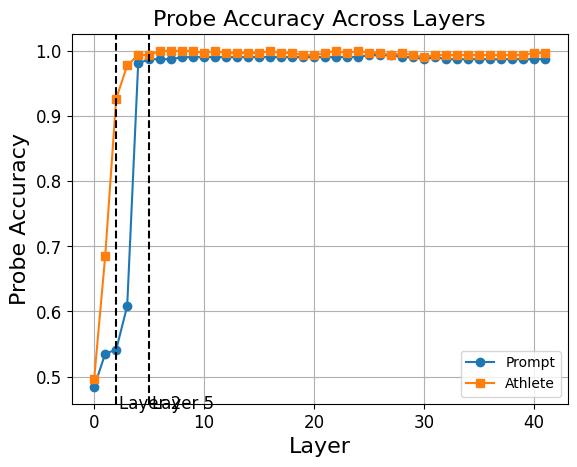

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=5, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(5.3, 0.45, 'Layer 5', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

### Ablate layer heads

In [ ]:
# Add mean ablate hooks
ablate_first_layer = 5

def mean_ablate_hook(act, hook, mean_cache):
    if hook.layer() >= ablate_first_layer:
        print(f'Hooked {hook.name}')
        act = mean_cache[hook.name]
    return act

model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results[f'Prompt + Ablate Heads at Layers >= {ablate_first_layer}'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist(), batch_size=128)

# Add mean ablate hooks
model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results[f'Athlete + Ablate Heads at Layers >= {ablate_first_layer}'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist(), batch_size=128)
model.reset_hooks()

torch.Size([1566, 24])
Hooked blocks.5.hook_attn_out
Hooked blocks.6.hook_attn_out
Hooked blocks.7.hook_attn_out
Hooked blocks.8.hook_attn_out
Hooked blocks.9.hook_attn_out
Hooked blocks.10.hook_attn_out
Hooked blocks.11.hook_attn_out
Hooked blocks.12.hook_attn_out
Hooked blocks.13.hook_attn_out
Hooked blocks.14.hook_attn_out
Hooked blocks.15.hook_attn_out
Hooked blocks.16.hook_attn_out
Hooked blocks.17.hook_attn_out
Hooked blocks.18.hook_attn_out
Hooked blocks.19.hook_attn_out
Hooked blocks.20.hook_attn_out
Hooked blocks.21.hook_attn_out
Hooked blocks.22.hook_attn_out
Hooked blocks.23.hook_attn_out
Hooked blocks.24.hook_attn_out
Hooked blocks.25.hook_attn_out
Hooked blocks.26.hook_attn_out
Hooked blocks.27.hook_attn_out
Hooked blocks.28.hook_attn_out
Hooked blocks.29.hook_attn_out
Hooked blocks.30.hook_attn_out
Hooked blocks.31.hook_attn_out
Hooked blocks.32.hook_attn_out
Hooked blocks.33.hook_attn_out
Hooked blocks.34.hook_attn_out
Hooked blocks.35.hook_attn_out
Hooked blocks.36.hook

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Time taken: 54.711870431900024 seconds
finished multiprocessing
[0.4840764331210191, 0.535031847133758, 0.5414012738853503, 0.60828025477707, 0.9808917197452229, 0.9840764331210191, 0.9777070063694268, 0.9777070063694268, 0.9777070063694268, 0.9713375796178344, 0.964968152866242, 0.9490445859872612, 0.9426751592356688, 0.9299363057324841, 0.9267515923566879, 0.9331210191082803, 0.9140127388535032, 0.9076433121019108, 0.9044585987261147, 0.910828025477707, 0.8980891719745223, 0.8980891719745223, 0.8853503184713376, 0.8853503184713376, 0.8726114649681529, 0.8789808917197452, 0.8248407643312102, 0.7961783439490446, 0.8057324840764332, 0.7834394904458599, 0.7515923566878981, 0.732484076433121, 0.7133757961783439, 0.7070063694267515, 0.6815286624203821, 0.6847133757961783, 0.6719745222929936, 0.6751592356687898, 0.6719745222929936, 0.6656050955414012, 0.6687898089171974, 0.6719745222929936]
{0: 0.4840764331210191, 1: 0.535031847133758, 2: 0.5414012738853503, 3: 0.60828025477707, 4: 0.980891

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Time taken: 54.88229584693909 seconds
finished multiprocessing
[0.4968152866242038, 0.6847133757961783, 0.9267515923566879, 0.9777070063694268, 0.9936305732484076, 0.9936305732484076, 0.9904458598726115, 0.9872611464968153, 0.9936305732484076, 0.9872611464968153, 0.9904458598726115, 0.9904458598726115, 0.9840764331210191, 0.9904458598726115, 0.9904458598726115, 0.9904458598726115, 0.9904458598726115, 0.9936305732484076, 0.9936305732484076, 0.9936305732484076, 0.9904458598726115, 0.9872611464968153, 0.9840764331210191, 0.9840764331210191, 0.9808917197452229, 0.9777070063694268, 0.9777070063694268, 0.9777070063694268, 0.9585987261146497, 0.9554140127388535, 0.9363057324840764, 0.9394904458598726, 0.9299363057324841, 0.9267515923566879, 0.9299363057324841, 0.9299363057324841, 0.9299363057324841, 0.9235668789808917, 0.9203821656050956, 0.9203821656050956, 0.9203821656050956, 0.9140127388535032]
{0: 0.4968152866242038, 1: 0.6847133757961783, 2: 0.9267515923566879, 3: 0.9777070063694268, 4: 

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


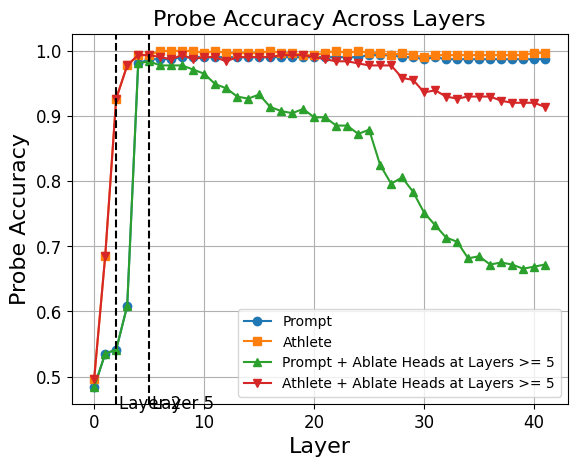

(50859081728, 85167243264)


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=5, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(5.3, 0.45, 'Layer 5', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()
print(torch.cuda.mem_get_info())

## Early attention heads

In [ ]:
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name
m_cache = get_mean_cache(model, hook_name="hook_z")
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq head d_model -> 1 1 head d_model',
        'mean'
    )
print(torch.cuda.mem_get_info())

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

(50863276032, 85167243264)


In [ ]:
ablate_first_layer = 5
def act_patch_hook_z(act, hook, patch_cache, patch_layer, patch_head):
    # heads_to_patch is [(layer, head)]
    # heads = [head for layer, head in heads_to_patch if layer == hook.layer()]

    # act is batch head seq d_model

    # want to patch head and every head after layer ablate_first_layer
    if hook.layer() == patch_layer:
        act[:, :, patch_head, :] = patch_cache[hook.name][:, :, patch_head, :]
    elif hook.layer() >= ablate_first_layer:
        act = patch_cache[hook.name]

    return act


layer_range = range(0, ablate_first_layer)
head_range = range(0, model.cfg.n_heads)

heads_to_patch = [
    (layer, head)
    for layer in layer_range
    for head in head_range
]

# Get patch cache
# results_mat = torch.zeros((len(list(layer_range)), len(list(head_range))), device=device)
# for (layer, head) in tqdm(heads_to_patch):
#     # print(f'Patching L{layer}H{head}')

#     model.reset_hooks()

#     model.add_hook(
#         lambda name: 'hook_z' in name,
#         functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=layer, patch_head=head),
#         "fwd"
#     )

#     results_mat[layer, head] += probe_last_layer(model, full_prompt_toks, df['sport'].tolist(), batch_size=64, layer=ablate_first_layer) 

#     model.reset_hooks()
# torch.save(results_mat, f'results/9b_patch_results_{ablate_first_layer=}.pt')

results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')

/tmp/ipykernel_2267936/1760785832.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


In [ ]:
# Get baseline accuracy
model.reset_hooks()
model.add_hook(
    lambda name: 'hook_z' in name,
    functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=-1, patch_head=-1),
    "fwd"
)

baseline_acc = probe_last_layer(model, full_prompt_toks, df['sport'].tolist(), layer=ablate_first_layer, batch_size=64) 

model.reset_hooks()

last layer probe, cache shape:  torch.Size([1566, 3584])
(1566, 3584) 1566
Accuracy: 0.9808917197452229


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/tmp/ipykernel_2267936/2255518465.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


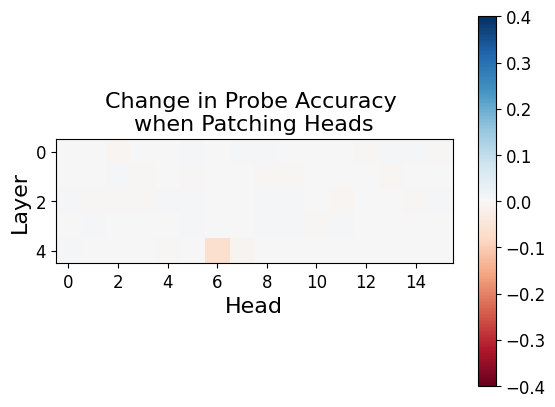

In [ ]:
results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy() - baseline_acc, cmap='RdBu', vmax=.4, vmin=-.4)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Change in Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
fig.savefig(f'results/9b_patch_heatmap_{ablate_first_layer=}.pdf')

/tmp/ipykernel_2267936/4258570237.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


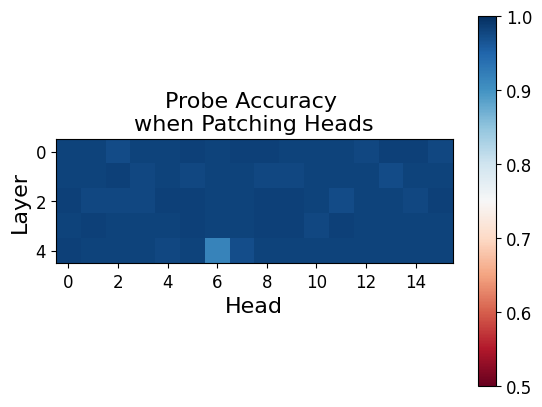

In [ ]:
results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy(), cmap='RdBu', vmax=1, vmin=0.5)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
# fig.savefig(f'results/9b_patch_heatmap_{ablate_first_layer=}.pdf')